## Prevendo preços de alugueis de apartamentos em São Paulo

### Imports

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

px.set_mapbox_access_token(open('mapbox_token').read())

### Conhecendo o DataSet

In [2]:
df = pd.read_csv('sao-paulo-properties-april-2019.csv')
df.head(5)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


#### Vou trabalhar somente com os apartamentos que estão para alugar, então descarto os apartamentos à venda no dataset

In [3]:
df_aluguel = df[(df['Negotiation Type'] == 'rent')]

### Verificando a distribuição de preços no dataset

In [4]:
df_aluguel.describe()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Latitude,Longitude
count,7228.000000,7228.000000,7228.000000,7228.000000,7228.000000,7228.000000,7228.000000,7228.000000,7228.000000,7228.000000,7228.000000,7228.000000,7228.000000
mean,3077.669065,825.194798,89.486165,2.304234,2.105562,1.024488,1.452269,0.299806,0.172939,0.487963,0.000830,-22.032278,-43.500873
std,3522.830284,835.621937,63.976416,0.829108,0.998162,0.884241,0.889535,0.458205,0.378220,0.499890,0.028802,5.962534,11.675070
min,480.000000,0.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-46.749039,-58.364352
25%,1350.000000,395.750000,52.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-23.598066,-46.689788
50%,2000.000000,595.000000,67.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-23.555869,-46.644793
75%,3300.000000,990.000000,100.000000,3.000000,2.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,-23.522756,-46.585110
max,50000.000000,9500.000000,880.000000,10.000000,8.000000,5.000000,9.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000


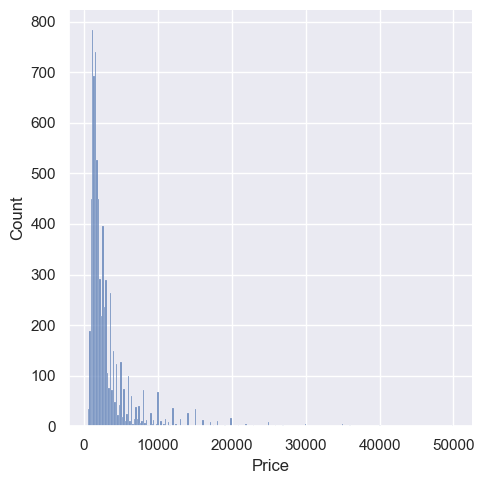

In [5]:
sns.set_theme(style="darkgrid")
sns.displot(df_aluguel, x='Price')

#### Relação entre preço e quantidade de garagens

<Axes: xlabel='Parking', ylabel='Price'>

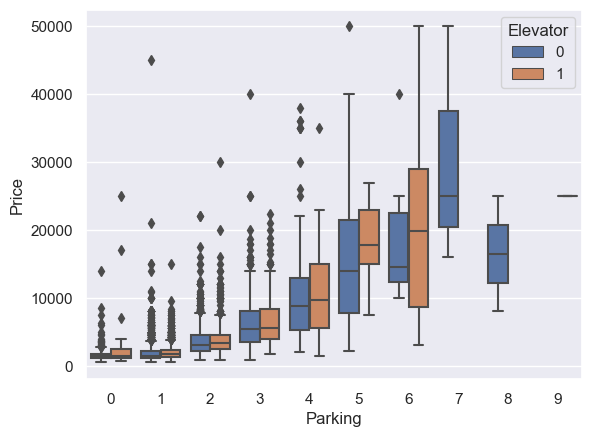

In [6]:
sns.boxplot(data=df_aluguel, x='Parking', y='Price', hue='Elevator')

#### Muitos apartamentos pequenos no dataset. Também podemos perceber que existem alguns apartamentos gigantes, porém com valores abaixo de 20k

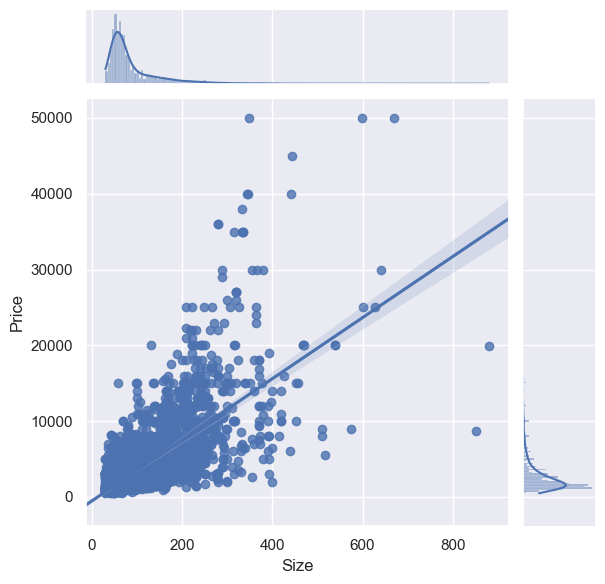

In [7]:
sns.jointplot(data=df_aluguel, x='Size', y='Price', kind='reg', truncate=False)
plt.show()

### Plotando um mapa interativo...
#### Removendo do meu dataset todos os apartamentos que estão com a latitude e longitude zeradas

In [8]:
df_aluguel = df_aluguel.drop(df_aluguel[df_aluguel['Latitude'] == 0].index)

### Com esse mapa, podemos ver facilmente os locais onde os apartamentos de luxo estão concentrados, assim como os apartamentos mais simples localizados nos bairros mais periféricos de SP

In [9]:
fig = px.scatter_mapbox(df_aluguel, lat='Latitude', lon='Longitude', size='Price', color='Price', 
                        color_continuous_scale=px.colors.cyclical.IceFire, opacity=0.5, size_max=20, zoom=11)
fig.update_coloraxes(colorscale = [[0, 'rgb(166,206,227, 0.5)'],
                      [0.02, 'rgb(31,120,180,0.5)'],
                      [0.05, 'rgb(178,223,138,0.5)'],
                      [0.10, 'rgb(51,160,44,0.5)'],
                      [0.15, 'rgb(251,154,153,0.5)'],
                      [1, 'rgb(227,26,28,0.5)']
                     ],                                  
                  )
fig.update_layout(width=1200, height=800)
fig.show()

### Finalizado essa primeira etapa de visualização dos nossos dados, agora partiremos rumo ao nosso objetivo que é predizer o valor de alugueis em SP

<p>Comecei removendo algumas colunas que eu não iria utilizar, como tipo de negociação, tipo de propriedade, novo, e distrito.</p>

In [10]:
df_aluguel.drop('Negotiation Type', axis=1, inplace=True)
df_aluguel.drop('Property Type', axis=1, inplace=True)
df_aluguel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6745 entries, 0 to 11209
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price          6745 non-null   int64  
 1   Condo          6745 non-null   int64  
 2   Size           6745 non-null   int64  
 3   Rooms          6745 non-null   int64  
 4   Toilets        6745 non-null   int64  
 5   Suites         6745 non-null   int64  
 6   Parking        6745 non-null   int64  
 7   Elevator       6745 non-null   int64  
 8   Furnished      6745 non-null   int64  
 9   Swimming Pool  6745 non-null   int64  
 10  New            6745 non-null   int64  
 11  District       6745 non-null   object 
 12  Latitude       6745 non-null   float64
 13  Longitude      6745 non-null   float64
dtypes: float64(2), int64(11), object(1)
memory usage: 790.4+ KB


### Verificando a correlação dos nossos dados

In [11]:
df_aluguel.corr(numeric_only=True)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Latitude,Longitude
Price,1.000000,0.698795,0.729313,0.387790,0.580760,0.585874,0.640286,0.030004,0.169041,0.202520,-0.009010,-0.005746,-0.026420
Condo,0.698795,1.000000,0.812949,0.493376,0.594019,0.595427,0.705965,0.016533,0.076482,0.193216,-0.012386,-0.000594,-0.035488
Size,0.729313,0.812949,1.000000,0.672032,0.691874,0.700650,0.756253,0.003277,0.005380,0.146043,-0.017304,-0.001987,-0.040546
Rooms,0.387790,0.493376,0.672032,1.000000,0.553179,0.541450,0.592508,-0.006773,-0.102772,0.153103,-0.023953,0.000658,-0.022191
Toilets,0.580760,0.594019,0.691874,0.553179,1.000000,0.916559,0.703598,0.136472,0.068957,0.253828,-0.009545,-0.006723,-0.014777
Suites,0.585874,0.595427,0.700650,0.541450,0.916559,1.000000,0.719844,0.098573,0.067643,0.257580,-0.008509,-0.007149,-0.014403
Parking,0.640286,0.705965,0.756253,0.592508,0.703598,0.719844,1.000000,0.020566,0.061546,0.298275,-0.005886,0.001848,-0.032372
Elevator,0.030004,0.016533,0.003277,-0.006773,0.136472,0.098573,0.020566,1.000000,0.099247,0.155396,0.036042,-0.042509,0.050298
Furnished,0.169041,0.076482,0.005380,-0.102772,0.068957,0.067643,0.061546,0.099247,1.000000,0.181049,0.004812,-0.019739,0.018730
Swimming Pool,0.202520,0.193216,0.146043,0.153103,0.253828,0.257580,0.298275,0.155396,0.181049,1.000000,0.012633,-0.031670,0.004908


### Transformando a variável distrito, em uma variável numerica, para melhor aprendizado do nosso modelo.

In [12]:
one_hot = pd.get_dummies(df_aluguel['District'])

In [13]:
df_aluguel.drop('District', axis=1, inplace=True)

In [14]:
df_aluguel.drop('New', axis=1, inplace=True)

In [15]:
df_aluguel = df_aluguel.join(one_hot)
df_aluguel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6745 entries, 0 to 11209
Columns: 106 entries, Price to Água Rasa/São Paulo
dtypes: float64(2), int64(10), uint8(94)
memory usage: 1.5 MB


### Dividindo nosso dataset em dados de treino, e dados de teste.
<p>Modelos de Machine Learning, primeiro treina em alguns dados, e depois nós validamos.</p>
<p>Nós não podemos mostrar nossos dados de teste a eles. Eles precisam aprender nos dados de treino, e então depois de treinado, nós damos a ele os dados de teste, para que ele possa tentar predizer informações que nunca viu.</p>
<p>Decidi dividir nosso dataset em 80% de dados de treino, e 20% de dados de teste.</p>

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score

X = df_aluguel[df_aluguel.columns[df_aluguel.columns != 'Price']]
Y = df_aluguel['Price']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

### Modelo de Regressão Linear

In [17]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
y_pred = lin_reg.predict(x_train)

#### Algumas predições do nosso modelo de Regressão Linear
<p>Podemos ver que nosso modelo errou alguns valores, achei uma média de erro bem alta, mas vamos verificar de forma mais detalhada.</p>

In [18]:
alguns_apartamentos = x_train.iloc[:5]
algumas_labels = y_train.iloc[:5]
print('Predições:', lin_reg.predict(alguns_apartamentos))
print('Labels:', algumas_labels.values)

Predições: [11209.62762835  1050.84736602 11913.19549951   653.28297011
  2221.34900448]
Labels: [11500  2300 30000  1300  2500]


### Avaliando nosso modelo.
<p>Essa é uma das partes mais importantes do nosso modelo de Machine Learning, nós podemos verificar algumas métricas e saber como nosso modelo está se saindo.
Verificamos que ele tem um coeficiente de determinação bastante baixo. Vamos tentar visualizar nas próximas células</p>

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lin_mse = mean_squared_error(y_train, y_pred)

lin_rmse = np.sqrt(lin_mse)
r2 = r2_score(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
print(f'Esse modelo erra em média: R${lin_rmse.round(2)}')
print(f'Seu coeficiente de determinação: {r2}')
print(f'Erro médio absoluto: {mae.round(2)}')
print('Cross validation score: ', cross_val_score(lin_reg, x_train, y_train, cv=3))

Esse modelo erra em média: R$1988.57
Seu coeficiente de determinação: 0.6974108699891641
Erro médio absoluto: 1019.46
Cross validation score:  [ 6.20254966e-01  7.32691139e-01 -7.99274985e+13]


### Plotando algumas predições do nosso modelo.
<p>Os pontos azuis são os valores reais dos apartamentos, e a linha vermelha, é o valor que nosso modelo previu.
Podemos perceber que nosso modelo até conseguiu prever valores de apartamentos mais baixos, porém deixou muito a desejar nos apartamentos mais caros.</p>

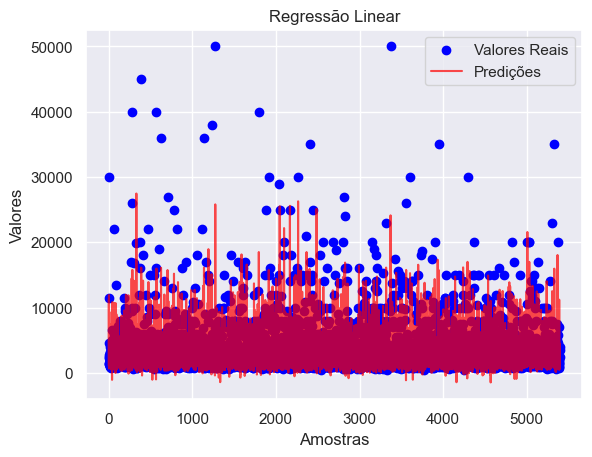

In [20]:
x = np.arange(len(y_pred))

plt.scatter(x, y_train, color='blue', label='Valores Reais')

plt.plot(x, y_pred, color='red', label='Predições', alpha = 0.7)

plt.xlabel('Amostras')
plt.ylabel('Valores')
plt.title('Regressão Linear')

plt.legend()
plt.show()


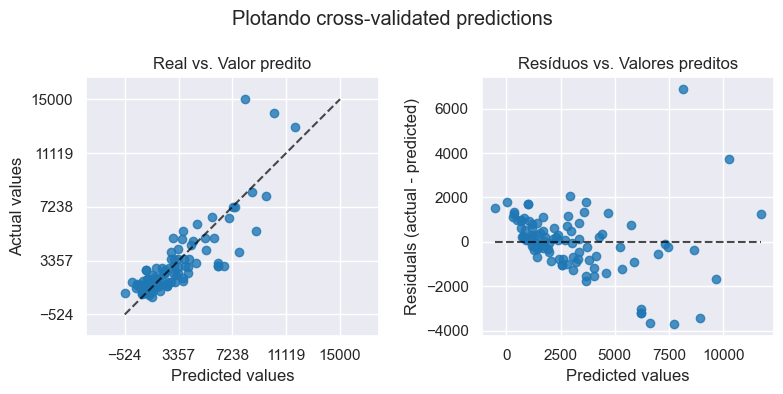

In [21]:
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_train,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Real vs. Valor predito")
PredictionErrorDisplay.from_predictions(
    y_train,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Resíduos vs. Valores preditos")
fig.suptitle("Plotando cross-validated predictions")
plt.tight_layout()
plt.show()

### Modelo de Arvore de Decisão
<p>Esse modelo especialmente, ele é muito bom nos dados de treino. Porém nos dados de teste, ele não se sai tão bem nesse caso. Pois ele se atém muito aos detalhes, e quando ele recebe apartamentos que nunca viu, ele se confunde por se apegar demais aos detalhes.</p>

In [22]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(x_train, y_train)

DecisionTreeRegressor()

In [37]:
y_pred_tree = tree.predict(x_train)
tree_mse = mean_squared_error(y_train, y_pred_tree)

tree_rmse = np.sqrt(tree_mse)
r2 = r2_score(y_train, y_pred_tree)
mae = mean_absolute_error(y_train, y_pred_tree)
print(f'Esse modelo erra em média: R${tree_rmse.round(2)}')
print(f'Seu coeficiente de determinação: {r2}')
print(f'Erro médio absoluto: {mae.round(2)}')
print('Cross validation score: ', cross_val_score(tree, x_train, y_train, cv=3))

Esse modelo erra em média: R$24.13
Seu coeficiente de determinação: 0.9999554364047467
Erro médio absoluto: 2.69
Cross validation score:  [0.4357096  0.49395376 0.40925614]


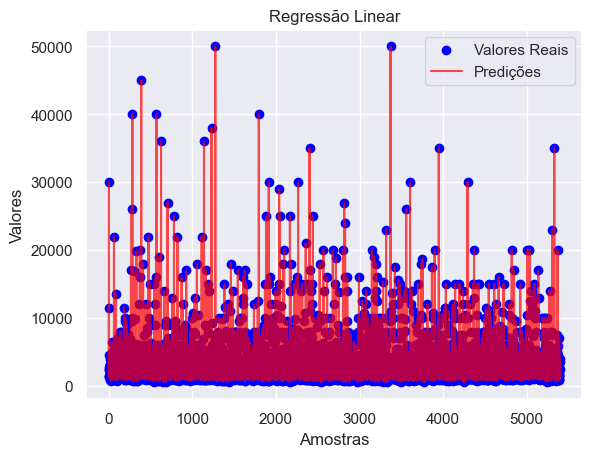

In [25]:
x = np.arange(len(y_pred_tree))

plt.scatter(x, y_train, color='blue', label='Valores Reais')

plt.plot(x, y_pred_tree, color='red', label='Predições', alpha = 0.7)

plt.xlabel('Amostras')
plt.ylabel('Valores')
plt.title('Regressão Linear')

plt.legend()
plt.show()


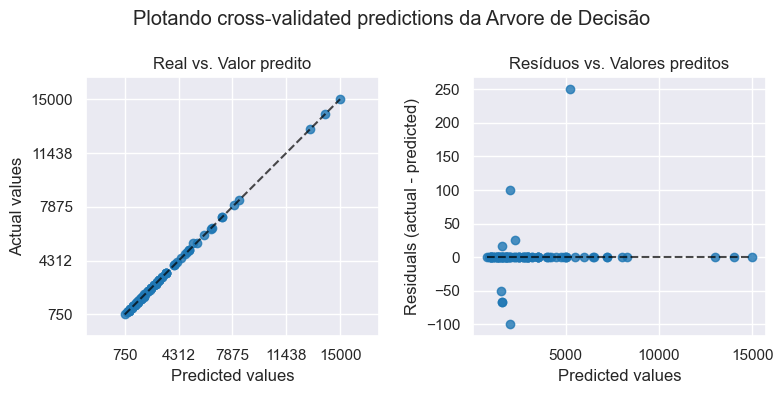

In [27]:
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_train,
    y_pred=y_pred_tree,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Real vs. Valor predito")
PredictionErrorDisplay.from_predictions(
    y_train,
    y_pred=y_pred_tree,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Resíduos vs. Valores preditos")
fig.suptitle("Plotando cross-validated predictions da Arvore de Decisão")
plt.tight_layout()
plt.show()

### Vamos tentar melhorar esse modelo de Arvore de Decisão
<p>Usando o GridSearchCV, nós conseguimos achar os melhores parâmetros possíveis para o nosso modelo. Porém, ele não teve uma pontuação tão boa...</p>

In [34]:
from sklearn.model_selection import GridSearchCV

model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')

grid_search.fit(x_train, y_train)

print('Melhores hiperparâmetros:', grid_search.best_params_)

print('Melhor pontuação:', grid_search.best_score_)

Melhores hiperparâmetros: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhor pontuação: 0.6174926849399631


### Modelo de Floresta Aleatória

In [35]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()
rf_reg.fit(x_train, y_train)

RandomForestRegressor()

<p>Não tão boa pontuação para o nosso modelo, porém, creio que ele se saia melhor que os modelos anteriores \o/</p>
<p></p>

In [38]:
y_pred_rf = rf_reg.predict(x_train)
rf_mse = mean_squared_error(y_train, y_pred_rf)

rf_rmse = np.sqrt(rf_mse)
r2 = r2_score(y_train, y_pred_rf)
mae = mean_absolute_error(y_train, y_pred_rf)
print(f'Esse modelo erra em média: R${rf_rmse.round(2)}')
print(f'Seu coeficiente de determinação: {r2}')
print(f'Erro médio absoluto: {mae.round(2)}')
print('Cross validation score: ', cross_val_score(rf_reg, x_train, y_train, cv=3))

Esse modelo erra em média: R$666.74
Seu coeficiente de determinação: 0.965983989678122
Erro médio absoluto: 267.96
Cross validation score:  [0.65898633 0.76293322 0.78042027]


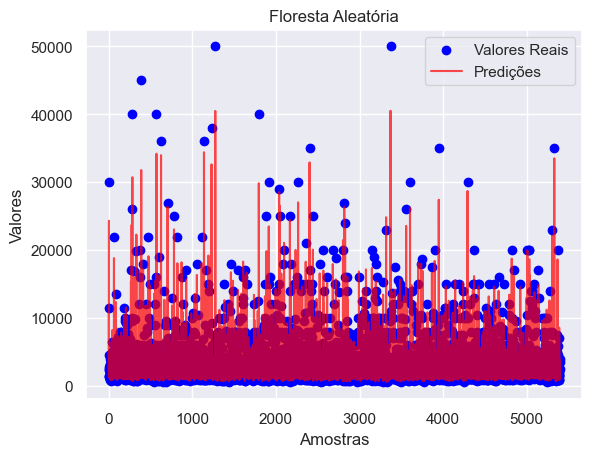

In [40]:
x = np.arange(len(y_pred_rf))

plt.scatter(x, y_train, color='blue', label='Valores Reais')

plt.plot(x, y_pred_rf, color='red', label='Predições', alpha = 0.7)

plt.xlabel('Amostras')
plt.ylabel('Valores')
plt.title('Floresta Aleatória')

plt.legend()
plt.show()


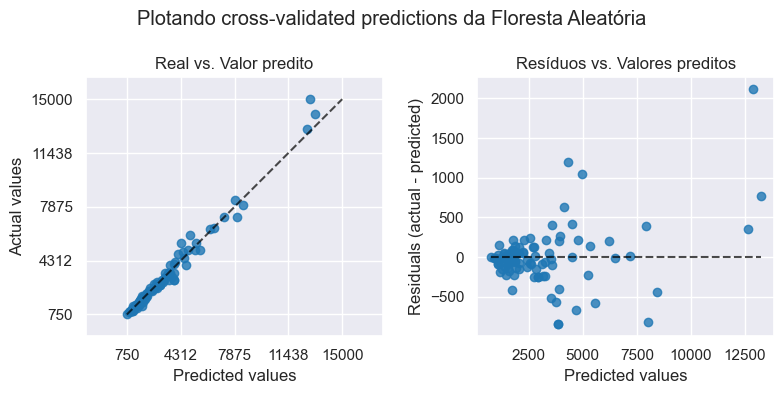

In [41]:
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_train,
    y_pred=y_pred_rf,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Real vs. Valor predito")
PredictionErrorDisplay.from_predictions(
    y_train,
    y_pred=y_pred_rf,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Resíduos vs. Valores preditos")
fig.suptitle("Plotando cross-validated predictions da Floresta Aleatória")
plt.tight_layout()
plt.show()

<p>Novamente vamos achar os melhores parâmetros possíveis para esse modelo de Floresta Aleatória</p>

In [42]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor()

param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')

grid_search.fit(x_train, y_train)

print('Melhores hiperparâmetros:', grid_search.best_params_)

print('Melhor pontuação:', grid_search.best_score_)

Melhores hiperparâmetros: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhor pontuação: 0.7096049307967256


In [43]:
final_model = grid_search.best_estimator_
final_model_predicts = final_model.predict(x_test)

final_mse = mean_squared_error(y_test, final_model_predicts)
print(np.sqrt(final_mse))

1760.785594376145


### Predição do nosso modelo:
<p>Visualmente podemos verificar que nosso modelo não se saiu tão bem em apartamentos que custam muito caro.
Existem algumas features importantes que não tinhamos no nosso dataset, como por exemplo: Vizinhança, proximidade do oceano, farmácias próximas, qualidade do asfalto, índice de violência, qualidade do ar, pintura nova, portas novas...
Percebe que poderiamos criar um modelo muito mais detalhado? Imagine se tivessemos essas features disponíveis no nosso dataset. Mesmo assim estou satisfeito com nosso modelo, obviamente o caminho até a perfeição é árduo e longo, e esse é apenas o início.
Sinta-se a vontade para baixar o código fonte.
Você pode entrar em contato comigo também.
Espero que tenham gostado. Esse é o resultado final do nosso modelo de inteligência artificial:</p>

In [45]:
fig = go.Figure(data=[go.Scatter(y=y_test.values, marker=dict(color='green'), name='Valores Reais'),
                     go.Scatter(y=final_model_predicts, marker=dict(color='red'), name='Previsões do modelo')])
fig.show()

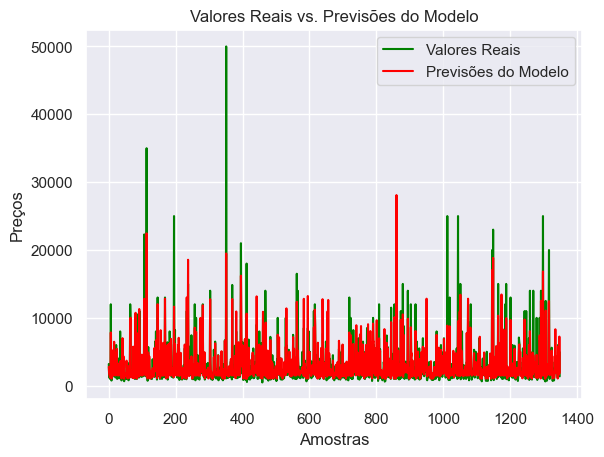

In [53]:


sns.lineplot(x=range(len(y_test)), y=y_test, color='green', label='Valores Reais')
sns.lineplot(x=range(len(final_model_predicts)), y=final_model_predicts, color='red', label='Previsões do Modelo')


plt.xlabel('Amostras')
plt.ylabel('Preços')
plt.title('Valores Reais vs. Previsões do Modelo')


plt.show()